# Loan Default Prediction Model - Logistic (Logit) Regression
This notebook aims to predict loan default outcomes based on historical loan data. The approach includes data preprocessing, model training, and evaluation using a logistic regression.

## Contents

Step 1. Data Loading and Initial Setup

Step 2. Data Preprocessing

Step 3. Feature Engineering

Step 4. Logit Model Fitting

Step 5: Feature Importance Analysis

Step 6: Model Evaluation

Step 7: Tradeoff Analysis

## Step 1. Data Loading and Initial Setup

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset and set display options
loan = pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan.set_index('id',inplace=True)
pd.set_option('display.max_columns', None)

## Step 2. Data Preprocessing

In [2]:
loan['home_ownership'].value_counts()

MORTGAGE    126680
RENT        109239
OWN          21638
OTHER          176
NONE            43
ANY              1
Name: home_ownership, dtype: int64

In [3]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation to avoid issues with regression
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

In [4]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

## Step 3. Feature Engineering

We'll now split the columns into numerical and categorical types. Categorical variables will be one-hot encoded, and numerical variables will be scaled to improve model performance.

In [ ]:
# Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
# dtype=int to get binary (0 or 1) values
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)

# Drop the following dummies to avoid dummy variable trap
# This ensures K-1 dummies for K groups
# Dropped dummies represent the base group
# The coefficients of the regressed dummies will be relative to the base group
X_encoded = X_encoded.drop(columns=['home_ownership_MORTGAGE','term_ 36 months','purpose_car','emp_length_0-1 years'])

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [6]:
# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Ensure y_train matches X_train, y_test matches X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [7]:
# Checking for higher collinear predictors
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_train.columns
# vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# print(vif_data)

## Step 4. Logit Model Fitting

We use the `statsmodels` library to run Logit Regression and print results

Optimization terminated successfully.
         Current function value: 0.486338
         Iterations 6


Text(0.01, 0.99, '                            Logit Regression Results                           \n===============================================================================\nDep. Variable:     loan_status_grouped   No. Observations:               206220\nModel:                           Logit   Df Residuals:                   206187\nMethod:                            MLE   Df Model:                           32\nDate:                 Thu, 07 Nov 2024   Pseudo R-squ.:                 0.06580\nTime:                         16:50:26   Log-Likelihood:            -1.0029e+05\nconverged:                        True   LL-Null:                   -1.0736e+05\nCovariance Type:             nonrobust   LLR p-value:                     0.000\n================================================================================================\n                                   coef    std err          z      P>|z|      [0.025      0.975]\n---------------------------------------------------------

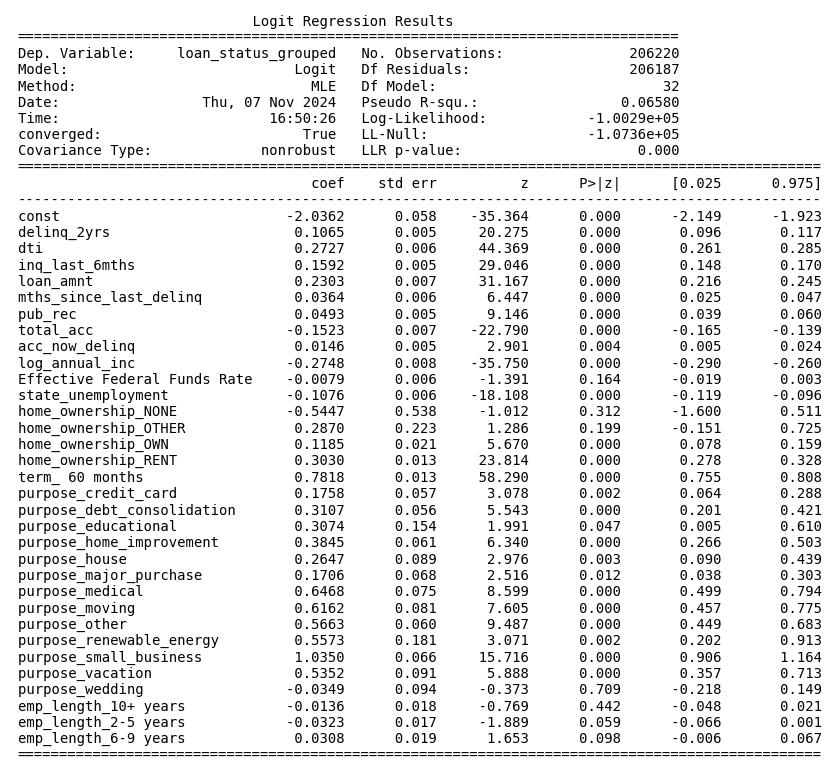

In [18]:
# Add a constant to the independent variables
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)

# Fit the model and obtain the result object
result = logit_model.fit(maxiter=1000)

# Print the summary of the logistic regression results
summary_text = str(result.summary())
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

ax.text(0.01, 0.99, summary_text, va="top", ha="left", fontsize=10, family="monospace")

As the coefficients of the logit model are "log odds", we obtain the marginal effects (dy/dx) which can be intepreted as below:

For a 1 unit increase in $X$, the probability of default changes by $dy/dx$.

Text(0.01, 0.99, '        Logit Marginal Effects        \n======================================\nDep. Variable:     loan_status_grouped\nMethod:                           dydx\nAt:                            overall\n================================================================================================\n                                  dy/dx    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------------------------\ndelinq_2yrs                      0.0167      0.001     20.331      0.000       0.015       0.018\ndti                              0.0428      0.001     44.936      0.000       0.041       0.045\ninq_last_6mths                   0.0250      0.001     29.202      0.000       0.023       0.027\nloan_amnt                        0.0361      0.001     31.334      0.000       0.034       0.038\nmths_since_last_delinq           0.0057      0.001      6.449      0.000       0.004       0.007

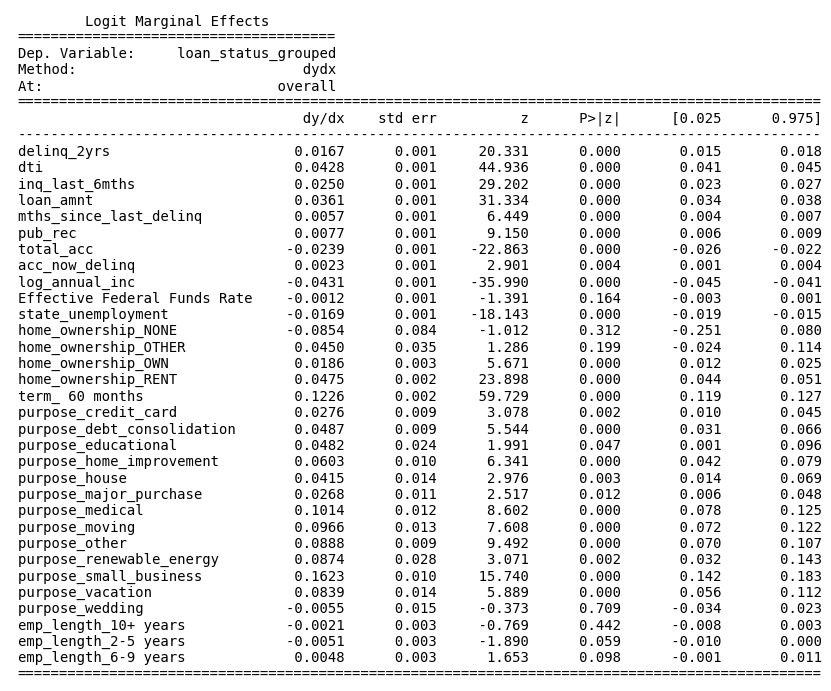

In [16]:
# Obtain marginal probabilities
marginal_prob = result.get_margeff()

# Show as image
summary_text = str(marginal_prob.summary())  

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")

ax.text(0.01, 0.99, summary_text, va="top", ha="left", fontsize=10, family="monospace")

## Step 5. Feature Importance Analysis

We can use the coefficients of the Logit model to rank the importance of features in the regression.

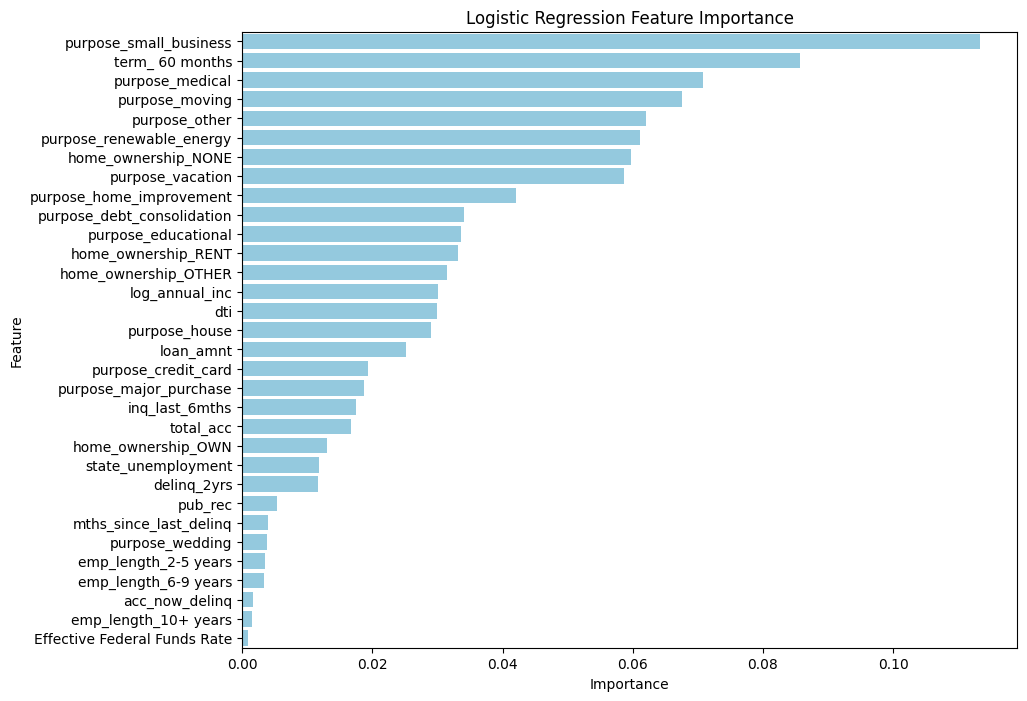

In [10]:
# Get the coefficients
coefficients = result.params

# Calculate the absolute importance values
feature_importance = np.abs(coefficients[1:])  # Exclude the intercept

# Scale the importance values by dividing by the total sum to get percentages
total_importance = feature_importance.sum()
percentage_importance = feature_importance / total_importance

# Create a DataFrame for better visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': percentage_importance
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Step 6. Model Evaluation

After training, the model is evaluated on the test set. We'll predict classes, generate a classification report, and plot a confusion matrix for performance visualization.

Accuracy: 0.61 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.59      0.70     40423
         1.0       0.31      0.67      0.42     11133

    accuracy                           0.61     51556
   macro avg       0.59      0.63      0.56     51556
weighted avg       0.75      0.61      0.64     51556



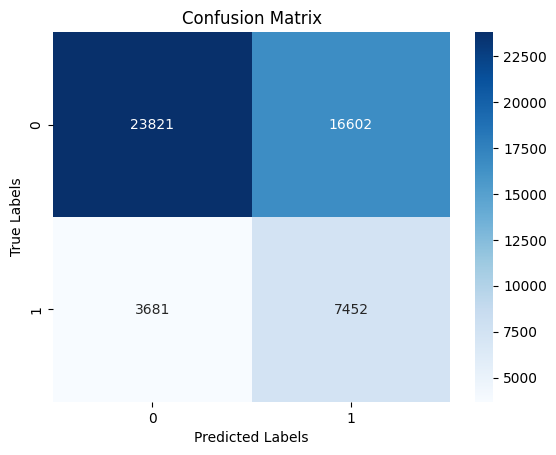

In [11]:
# Making predictions with a decision threshold
predicted_probs_test = result.predict(X_test_with_const)  
threshold = 0.2
y_pred = (predicted_probs_test >= threshold).astype(int)        

# Generating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.2f}', "\n")
print("Classification Report:\n", class_report)

# Plotting heatmap for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The predictions depend on the threshold. Probabilities below the threshold are classified as 0 (repaid) and above the threshold as 1 (defaulted).
A smaller threshold will result in less false negatives (defaulted loans classified as repaid), but a fewer number of total loans.

## Step 7. Tradeoff Analysis - TN/FN Ratio and Approved Loans

We can use the following code to calculate the TN/FN ratio and the approved loans.

Maximum TN/FN Ratio: 15.33 at Threshold: 0.06


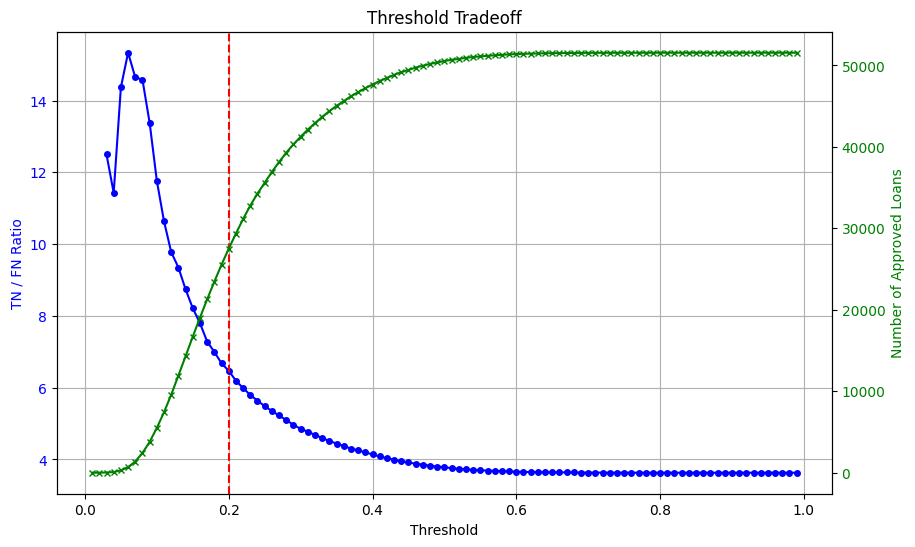

In [12]:
# Plotting True Negatives (TN) / False Negatives (FN) and number of approved loans against the threshold,

predicted_probs_test = result.predict(X_test_with_const)

ratios = []
approved_loans = []
thresholds = np.arange(0.01, 1.00, 0.01)

for threshold in thresholds:
    y_pred = (predicted_probs_test >= threshold).astype(int)
    TN = np.sum((y_pred == 0) & (y_test == 0))
    FN = np.sum((y_pred == 0) & (y_test == 1))
    
    if FN > 0:
        ratio = TN / FN
    else:
        ratio = np.nan 

    ratios.append(ratio)
    approved_loans.append(TN + FN)

# Filter out infinite and NaN ratios
valid_ratios = [(ratio, threshold) for ratio, threshold in zip(ratios, thresholds) if pd.notna(ratio) and ratio != np.inf]

# Find the maximum ratio and its corresponding threshold
if valid_ratios:
    max_ratio, best_threshold = max(valid_ratios, key=lambda x: x[0])

    # Print the threshold that gives the maximum ratio
    print(f'Maximum TN/FN Ratio: {max_ratio:.2f} at Threshold: {best_threshold:.2f}')
else:
    print("No valid ratios found.")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the TN/FN ratio on the primary y-axis
ax1.plot(thresholds, ratios, marker='o', markersize=4, color='b', label='TN / FN Ratio')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('TN / FN Ratio', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid()

# Create a secondary y-axis to plot the number of approved loans
ax2 = ax1.twinx()
ax2.plot(thresholds, approved_loans, marker='x', markersize=4, color='g', label='Number of Approved Loans')
ax2.set_ylabel('Number of Approved Loans', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Set limits for the y-axes
try:
    max_ratio_limit = max(filter(lambda x: x != np.inf, ratios), default=0)
    ax1.set_ylim(0, max_ratio_limit * 1.1)

    max_approved_loans_limit = max(approved_loans, default=0)
    ax2.set_ylim(0, max_approved_loans_limit * 1.1)
except ValueError:
    pass

# Plotting a vertical line at threshold = 0.2
ax1.axvline(x=0.2, color='r', linestyle='--', label='Threshold = 0.2')

plt.title('Threshold Tradeoff')

plt.show()
